<a href="https://colab.research.google.com/github/kavithasub/uh-study-modules/blob/main/data-science-project/project_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
 - Lungcancer is the leading cause of cancer death worldwide, with smoking being the primary risk factor.
 - Early detection and diagnosis can greatly increase the chances of survival; however, lung cancer is often diagnosed at an advanced stage due to the lack of early symptoms.
 - Early lung cancer stage prediction is crucial for treatment choices and prognosis, as accurate staging plays a major role. Lung cancer stages are categorized based on the size of the tumor and spreading behavior.


```
Stage I
Stage I lung cancer is a small tumor that has NOT spread to any lymph nodes.
Stage IA - tumor <= 3 cm [IA1, IA2]
Stage IB - tumor > 3 cm && <= 4 cm

Stage II
Stage IIA - tumor > 4 cm && <= 5 cm (NOT spread to the nearby lymph nodes).
Stage IIB - tumor <= 5 cm (spread to the lymph nodes within the lung) OR tumer > 5 cm (not spread to the lymph nodes).

Stage II tumors can be removed with surgery, but often additional treatments are recommended.

https://www.cancer.org/cancer/types/lung-cancer/detection-diagnosis-staging/staging-nsclc.html
```


 - Anaccurate lung cancer stage prediction might help reduce lung cancer mortality by motivating current smokers to quit and by identifying current smokers at high risk

# Project Title:
● Predict stage of lung cancer caused by smoking using machine learning models

# Objectives:
● Preprocess and analyze demographic and clinical data to identify key features
 related to lung cancer.

● Develop and compare machine learning models to predict the lung cancer stage.

● Evaluate model performance using accuracy, recall, F1-score and precision.

● Identify the most important features contributing to lung cancer by stage.

● Provide insights and recommendations for smoker lung cancer stage detection based on model findings.

# Imports

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, classification_report, det_curve, confusion_matrix
from scipy.stats import randint


# Data Cleaning and Preprocessing

###Read CSV

In [2]:
df = pd.read_csv('/content/drive/MyDrive/sample_data/lung_cancer.csv')
df.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,Male,White,Current,NaN,NaN
1,100002,66,Male,White,Current,NaN,NaN
2,100003,64,Male,White,Current,NaN,NaN
3,100004,60,Male,White,Former,NaN,NaN
4,100005,64,Male,White,Former,NaN,NaN


####Description of attributes
pid - anonymous identifier of a person;
age - age of a person at the start of the trial;
gender - Male/Female;
race - the race of a person;

smoker - Former/Current (Former is defined as quit smoking in last 15 years);

days_to_cancer - number of days passed since the trial when the cancer was first observed;

stage_of_cancer - the stage of cancer when the cancer was first observed;

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53427 entries, 0 to 53426
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pid              53427 non-null  int64  
 1   age              53427 non-null  int64  
 2   gender           53427 non-null  object 
 3   race             53166 non-null  object 
 4   smoker           53427 non-null  object 
 5   days_to_cancer   2033 non-null   float64
 6   stage_of_cancer  2032 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [4]:
df.shape

(53427, 7)

In [5]:
df.describe()

,pid,age,days_to_cancer
count,53427.000000,53427.000000,2033.000000
mean,149778.048346,61.417448,1047.207083
std,44860.640458,5.023601,743.052899
min,100001.000000,43.000000,0.000000
25%,113363.500000,57.000000,398.000000
50%,126734.000000,60.000000,928.000000
75%,205491.500000,65.000000,1722.000000
max,218894.000000,79.000000,2618.000000


### Get value counts for each attributes

In [6]:
## Get value counts for each attributes
def get_value_counts(dataframe,col_list):
    for col in col_list:
        print(dataframe[col].value_counts())
        print('\n')

In [7]:
get_value_counts(df, ['gender', 'smoker', 'race', 'stage_of_cancer'])

## Result shows value counts are not in other type

gender
Male      31517
Female    21910
Name: count, dtype: int64


smoker
Former     27680
Current    25747
Name: count, dtype: int64


race
White                                        48527
Black or African-American                     2375
Asian                                         1095
More than one race                             678
Native Hawaiian or Other Pacific Islander      192
American Indian or Alaskan Native              190
Participant refused to answer                  109
Name: count, dtype: int64


stage_of_cancer
IA      621
IV      596
IIIB    246
IIIA    213
IB      210
IIB      79
IIA      67
Name: count, dtype: int64




### Check NAN valued attributes

In [8]:
df['stage_of_cancer'].unique()

array([nan, 'IA', 'IIB', 'IV', 'IIIB', 'IIIA', 'IIA', 'IB'], dtype=object)

In [9]:
df['race'].unique()

array(['White', 'Native Hawaiian or Other Pacific Islander',
       'More than one race', 'Asian', nan, 'Black or African-American',
       'American Indian or Alaskan Native',
       'Participant refused to answer'], dtype=object)

In [10]:
df['days_to_cancer'].unique()

array([  nan,  454., 2428., ..., 2220., 1077., 1632.])

### Replace NAN values



In [11]:
df_lung_cancer = df.fillna({'stage_of_cancer':0, 'days_to_cancer':0, 'race':'Other'})
df_lung_cancer.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,Male,White,Current,0.0,0
1,100002,66,Male,White,Current,0.0,0
2,100003,64,Male,White,Current,0.0,0
3,100004,60,Male,White,Former,0.0,0
4,100005,64,Male,White,Former,0.0,0


### Find missing values
missing data can be removed if very less amount of data else it can be filled with mean values.

In [12]:
df_lung_cancer.isnull().sum()

,0
pid,0
age,0
gender,0
race,0
smoker,0
days_to_cancer,0
stage_of_cancer,0


**There is no missing values in this data set**

### Convert categorical values of stage_of_cancer to 1,2,0

In [13]:
pd.set_option('future.no_silent_downcasting', True)

In [14]:
df_lung_cancer['stage_of_cancer'] = df_lung_cancer['stage_of_cancer'].replace({'IA': 1, 'IB' : 1,'IIA':1,
                                                       'IIB':1,'IIIA':2,'IIIB':2,'IV':2})

# Exploratory Data Analysis

### Plot few graphs to understand interelations of attributes

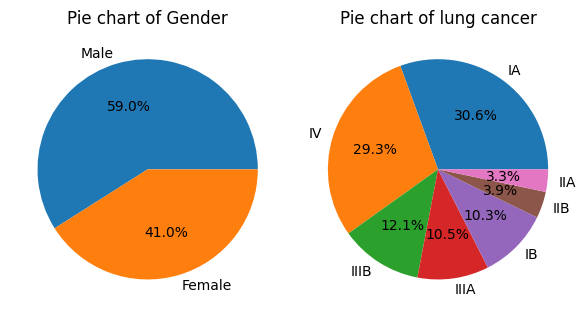

In [15]:
## Draw pie chart for gender and lung cancer distribution
fig,axes = plt.subplots(1,2,figsize=(6,6))
axes[0].pie(df_lung_cancer['gender'].value_counts(),labels=df_lung_cancer['gender'].value_counts().index,autopct='%1.1f%%')
axes[0].set_title('Pie chart of Gender')
axes[1].pie(df['stage_of_cancer'].value_counts(),labels=df['stage_of_cancer'].value_counts().index, autopct='%1.1f%%')
axes[1].set_title('Pie chart of lung cancer')
plt.tight_layout()
plt.show()

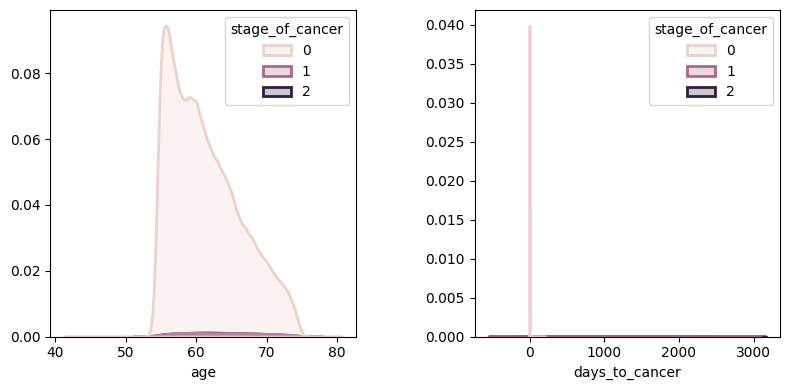

In [16]:
## More plots to see distributions
select_cols = ['stage_of_cancer', 'age', 'days_to_cancer']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()

for i, col in enumerate(df_lung_cancer[select_cols].columns[1:]):
    sns.kdeplot(x=col, data=df_lung_cancer, ax=ax[i], fill=True, lw=2, hue = 'stage_of_cancer')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('')

plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

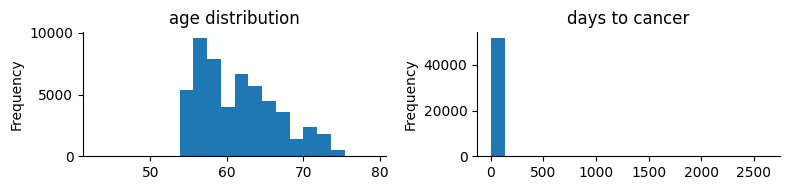

In [17]:
fig,axes = plt.subplots(1,2,figsize=(8,2))

df_lung_cancer['age'].plot(kind='hist', bins=20, title='age distribution', ax=axes[0])
axes[0].spines[['top', 'right',]].set_visible(False)
df_lung_cancer['days_to_cancer'].plot(kind='hist', bins=20, title='days to cancer', ax=axes[1])
axes[1].spines[['top', 'right',]].set_visible(False)


plt.tight_layout()
plt.show()

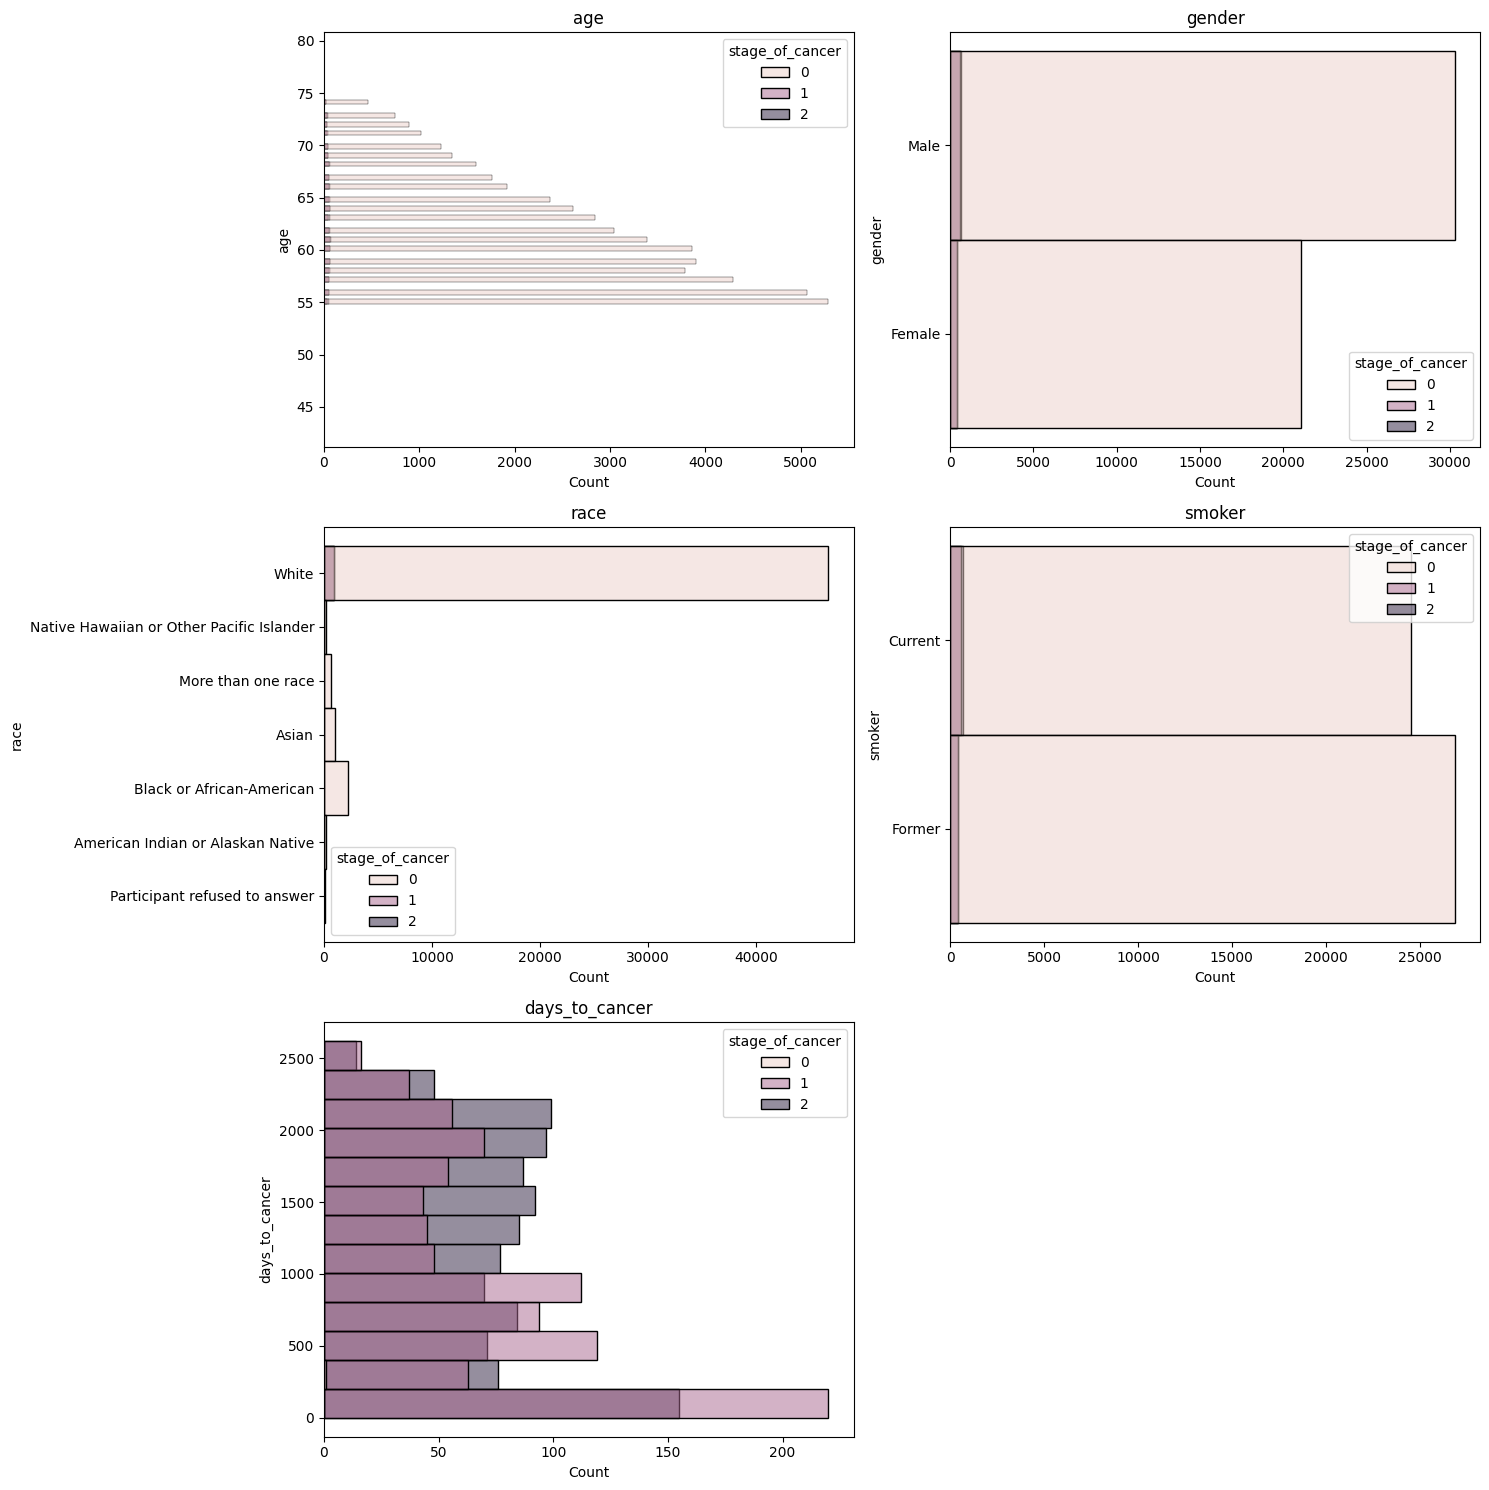

In [18]:
col=['age', 'gender', 'race', 'smoker', 'days_to_cancer']
fig = plt.figure(figsize=(15,15))

for i in range(len(col)):
    plt.subplot(3,2,i+1)
    plt.title(col[i])
    sns.histplot(data=df_lung_cancer,y=df[col[i]],hue='stage_of_cancer')

plt.tight_layout()
plt.show()

###❗Redo analysis with cancer stage 1 and stage 2 due to the stage 0 has high number of records which can cause error

Dataframe with stage 0 (non cancer records) dropped

In [19]:
df_lung_cancer_new = df_lung_cancer[df_lung_cancer['stage_of_cancer'] > 0]

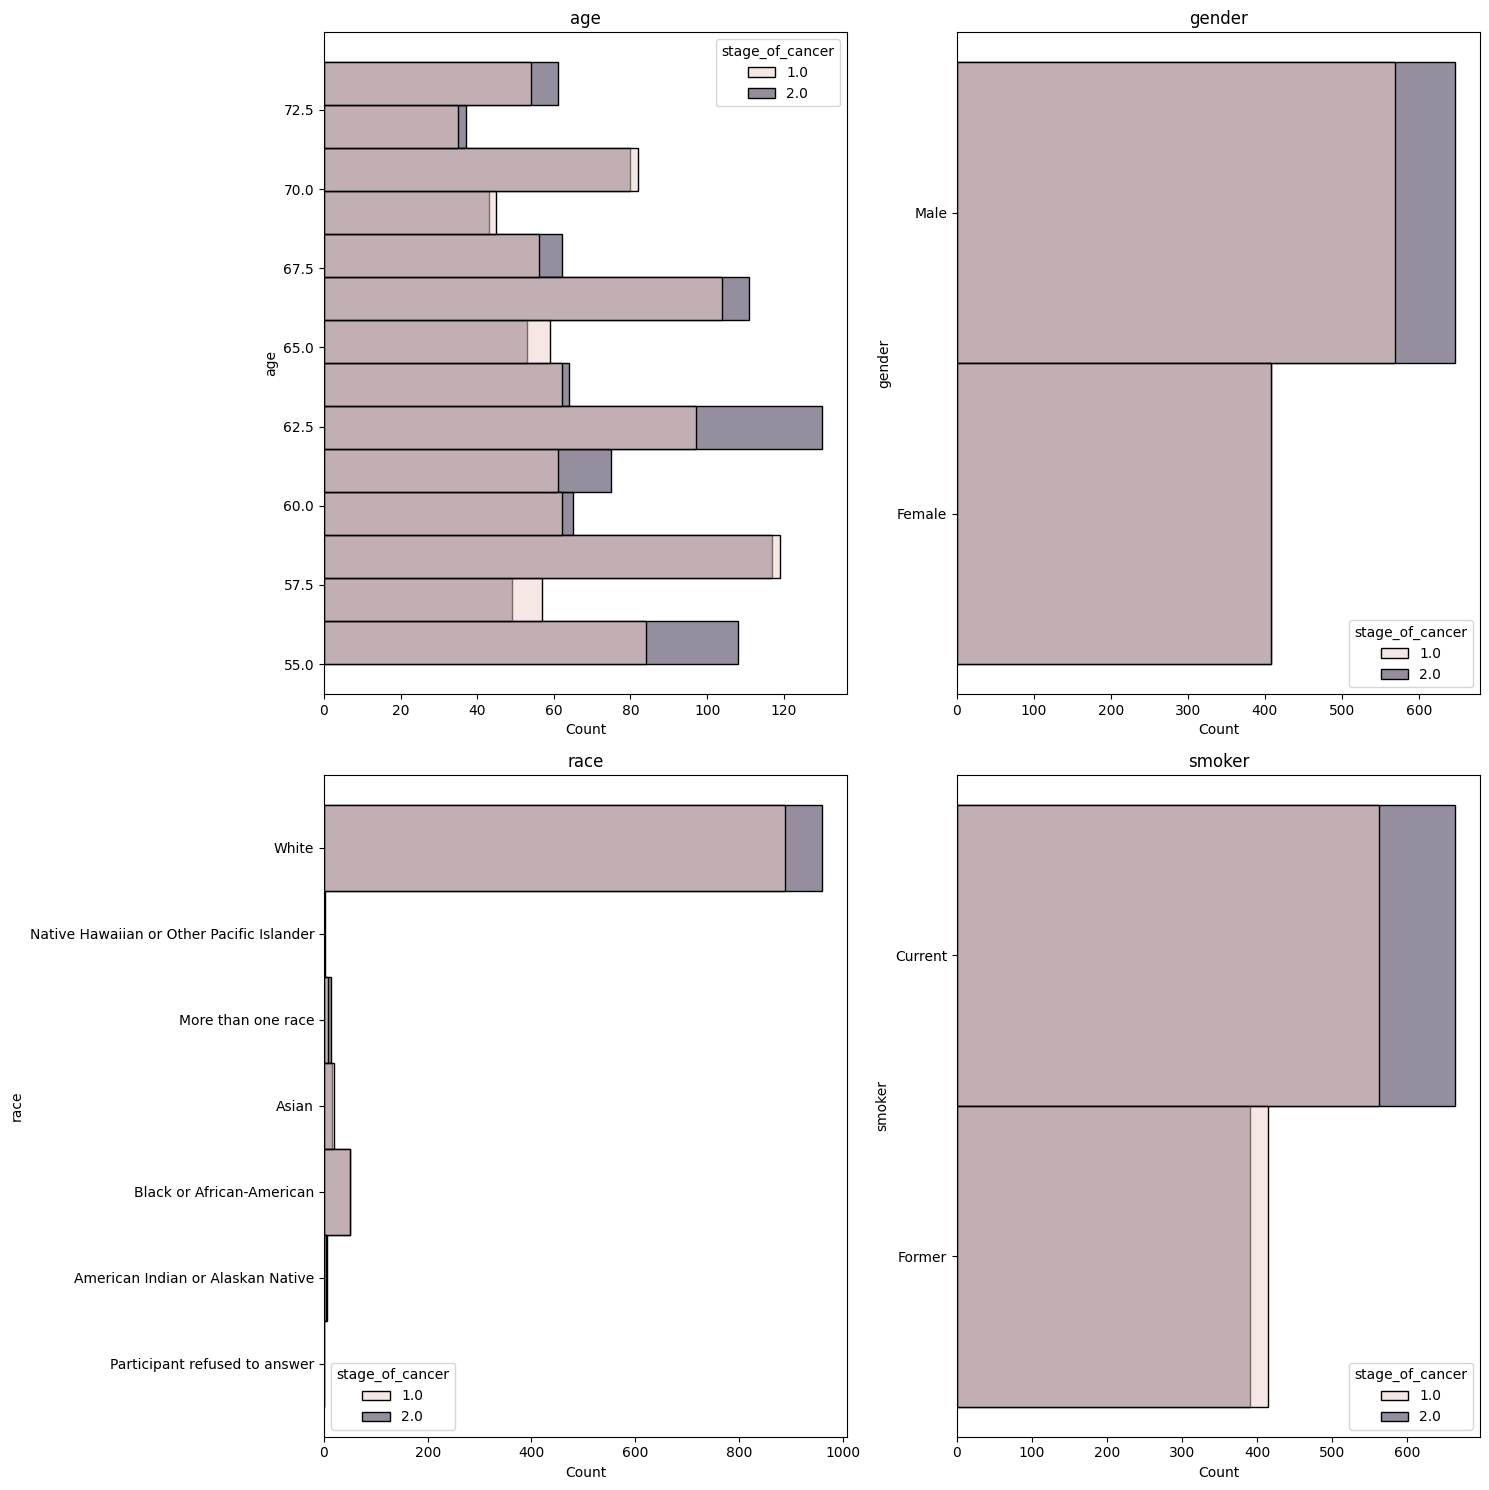

In [20]:
# Histograms of features by stage_of_cancer
cols=['age', 'gender', 'race', 'smoker']
fig = plt.figure(figsize=(15,15))

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    plt.title(cols[i])
    sns.histplot(data=df_lung_cancer_new, y=df[cols[i]], hue='stage_of_cancer')

plt.tight_layout()
plt.show()

**High stage of cancer found in male current smokers**

Couldn't plot correlation table(heatmap to see relationship between attributes) because most attributes are catgorical

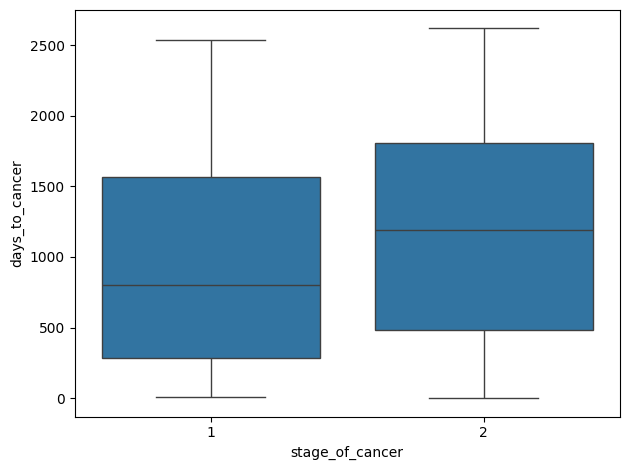

In [21]:
# Find outliers

sns.boxplot(x='stage_of_cancer', y='days_to_cancer', data=df_lung_cancer_new)
plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

### Data transformation

In [22]:
## Encode values for categorical type attributes
category_cols = ['gender', 'race', 'smoker', 'stage_of_cancer']

le = LabelEncoder()
for label in category_cols:
    df_lung_cancer[label] = le.fit_transform(df_lung_cancer[label])
df_lung_cancer.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,1,7,0,0.0,0
1,100002,66,1,7,0,0.0,0
2,100003,64,1,7,0,0.0,0
3,100004,60,1,7,1,0.0,0
4,100005,64,1,7,1,0.0,0


In [23]:
df_lung_cancer['stage_of_cancer'].unique()

array([0, 1, 2])

# Model definition, Training and Prediction

In [24]:
## Re create dataset with dropped stage 0 (non cancer records)
df_lung_cancer_new = df_lung_cancer[df_lung_cancer['stage_of_cancer'] > 0]

In [25]:
df_lung_cancer_new['stage_of_cancer'].unique()

array([1, 2])

###Split the data into training and test subsets

In [26]:
## Separate target variable from features
X = df_lung_cancer_new.drop(['pid','stage_of_cancer'],axis=1)
y = df_lung_cancer_new['stage_of_cancer']

In [27]:
## train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


### Apply standard scaler to transform data to same structure

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


## Smoker Lung Cancer Stage Classification Model

### 1. Logistic Regression

In [36]:
## Logistic Regression
lr_model = LogisticRegression(max_iter=1000)


In [37]:
lr_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=1000)

In [38]:
lr_model.score(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.5126153846153846

In [39]:
lr_pred = lr_model.predict(X_test_sc)

#### Find Measures

In [40]:
## find accuracy on test set
lr_acc = accuracy_score(y_test, lr_pred)

print('Accuracy score on Test: ', lr_acc)

#print('Training Accuracy: ', accuracy_score(X_train_sc, y_train))

Accuracy score on Test:  0.5872235872235873


In [41]:
## find recall and precision scores on test set
lr_rec = recall_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)

print('Recall score on Test: ', lr_rec)
print('Precision score on Test: ', lr_prec)

Recall score on Test:  0.5675675675675675
Precision score on Test:  0.5440414507772021


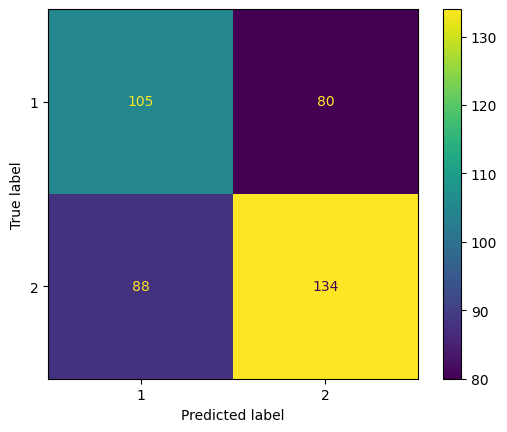

In [42]:
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_sc , y_test);

### 2. Random Forest Clasifier

In [43]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)


In [44]:
rf_model.fit(X_train_sc , y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [45]:
rf_model.score(X_train_sc , y_train)

0.9981538461538462

In [46]:
rf_pred = rf_model.predict(X_test_sc)

#### Find Measures

In [47]:
## find accuracy on test set
rf_acc = accuracy_score(y_test , rf_pred)

print('Accuracy score on Test: ', rf_acc)


Accuracy score on Test:  0.542997542997543


In [48]:
rf_rec = recall_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
print('Recall score of Random Forest Classifier: ', rf_rec)
print('Precision score of Random Forest Classifier: ', rf_prec)

Recall score of Random Forest Classifier:  0.518918918918919
Precision score of Random Forest Classifier:  0.49740932642487046


Confusion Matrix: 
 [[ 96  89]
 [ 97 125]]


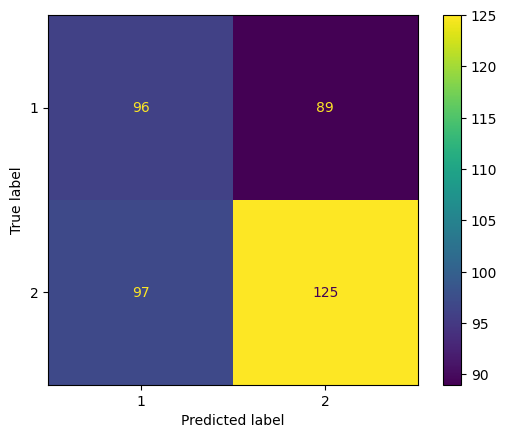

In [49]:
print('Confusion Matrix: \n', confusion_matrix(y_test,rf_pred))
ConfusionMatrixDisplay.from_estimator(rf_model , X_test_sc , y_test);

### 3. K-Nearest Neighbours

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [30]:
knn_model.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [31]:
knn_model.score(X_train_sc , y_train)

0.7273846153846154

In [32]:
knn_pred = knn_model.predict(X_test_sc)

#### Find Measures

In [33]:
## find accuracy on test set
knn_acc = accuracy_score(y_test , knn_pred)

print('Accuracy score of KNN on Test: ', knn_acc)


Accuracy score of KNN on Test:  0.542997542997543


In [35]:
knn_rec = recall_score(y_test, knn_pred)
knn_prec = precision_score(y_test, knn_pred)
print('Recall score of KNN: ', knn_rec)
print('Precision score of KNN: ', knn_prec)

Recall score of KNN:  0.4972972972972973
Precision score of KNN:  0.4972972972972973


Confusion Matrix: 
 [[ 92  93]
 [ 93 129]]


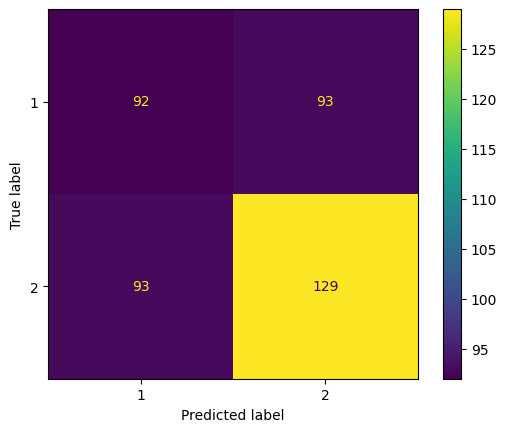

In [34]:
print('Confusion Matrix: \n', confusion_matrix(y_test, knn_pred))
ConfusionMatrixDisplay.from_estimator(knn_model , X_test_sc , y_test);

# Evaluate Model and Tune Perfomance

### Score summary of models

In [50]:
## Display as table
scores = pd.DataFrame(columns = ["LRC", "RFC", "KNN"], index = ["ACC", "REC", "PREC"])
acc = [lr_acc, rf_acc, knn_acc]
scores.iloc[0, :] = acc
rec = [lr_rec, rf_rec, knn_rec]
scores.iloc[1, :] = rec
prec = [lr_prec, rf_prec, knn_prec]
scores.iloc[2, :] = prec
scores

,LRC,RFC,KNN
ACC,0.587224,0.542998,0.542998
REC,0.567568,0.518919,0.497297
PREC,0.544041,0.497409,0.497297


In [53]:
print('classification report - Logistic Regression\n Base model\n\n', classification_report(y_test , lr_pred))

classification report - Logistic Regression
 Base model

               precision    recall  f1-score   support

           1       0.54      0.57      0.56       185
           2       0.63      0.60      0.61       222

    accuracy                           0.59       407
   macro avg       0.59      0.59      0.59       407
weighted avg       0.59      0.59      0.59       407



In [52]:
print('classification report - Random Forest\n Base model\n\n', classification_report(y_test , rf_pred))

classification report - Random Forest
 Base model

               precision    recall  f1-score   support

           1       0.50      0.52      0.51       185
           2       0.58      0.56      0.57       222

    accuracy                           0.54       407
   macro avg       0.54      0.54      0.54       407
weighted avg       0.54      0.54      0.54       407



In [54]:
print('classification report -  KNN\n Base model\n\n', classification_report(y_test , knn_pred))

classification report -  KNN
 Base model

               precision    recall  f1-score   support

           1       0.50      0.50      0.50       185
           2       0.58      0.58      0.58       222

    accuracy                           0.54       407
   macro avg       0.54      0.54      0.54       407
weighted avg       0.54      0.54      0.54       407



**So far, comparitively, the accuracy score of Logistic regression model is little high than other models.**


**According to confusion matrix, the number of stage 1 cancer incorrectly predicted as stage 2 cancer (false positive) is comparitively less but, is not considerable difference**

⏰**Need to do:**
- Fix measurement issues
- Reserach on performance tuning techniques:- ✔ Identified 1. hyperparameter grid search for RF, 2. Principal component analysis for LR
- Trial and error best performance tuning technique
- Select best model
- Evaluate the model:- e.g. using learning curve, ROC curve, feature importance etc


### Using Hyper parameter optimization technique to tune the model

#### Apply Random Search for RF

In [34]:
## Define the parameters for random search
# n_estimators - Number of trees in random forest
# max_depth - Maximum number of levels in tree

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,30)}

#print(param_dist)
rf_random_model = RandomForestClassifier()


rf_random_search = RandomizedSearchCV(estimator = rf_random_model, param_distributions = param_dist, n_iter=7)
rf_random_search.fit(X_train_sc, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5b7db00460>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5b7dae23e0>})

In [35]:
## Find best params

rf_random_search.best_params_

{'max_depth': 2, 'n_estimators': 341}

**Evaluting random search tuned model with base model**

In [83]:
## Define evaluation method

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [44]:
## Base model results

base_model_acc = evaluate(rf_model, X_test_sc, y_test)

Model Performance
Average Error: 0.4570 degrees.
Accuracy = 66.22%.


In [45]:
## random search model results

random_best = rf_random_search.best_estimator_
random_model_acc = evaluate(random_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4005 degrees.
Accuracy = 71.50%.


In [46]:
## Compare model results

print('Improvement of {:0.2f}%.'.format( 100 * (random_model_acc - base_model_acc) / base_model_acc))

Improvement of 7.98%.


**We achieved an improvement of 7.61% in accuracy by using random search tuning method. Further, this may be increased using grid search technique.**

#### Apply Grid Search for RF

In [56]:
## Define the parameters for grid search

rf_param_grid = {'n_estimators': [100, 200, 300, 500],
              'max_depth': [10, 15, 20]}

rf_grid_model = RandomForestClassifier()

rf_grid_search = GridSearchCV(estimator = rf_grid_model, param_grid= rf_param_grid, n_jobs= 2)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [100, 200, 300, 500]})

In [67]:
## Train model and Find best params

rf_grid_search.fit(X_train_sc, y_train)

rf_grid_search.best_params_

{'max_depth': 10, 'n_estimators': 100}

**Evaluting gid search tuned model with base model**

In [68]:
## grid search model results

grid_best = rf_grid_search.best_estimator_
grid_model_acc = evaluate(grid_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4349 degrees.
Accuracy = 67.20%.


In [69]:
## Compare model results

print('Improvement of {:0.2f}%.'.format( 100 * (grid_model_acc - base_model_acc) / base_model_acc))

Improvement of 1.48%.


evaluate further with graphs

In [50]:
rf_random_pred = rf_random_search.predict(X_test_sc)
print('classification report - Random Forest\n Tunned with Random search method\n\n', classification_report(y_test , rf_random_pred))

classification report - Random Forest
 Tunned with Random search method

               precision    recall  f1-score   support

           1       0.55      0.63      0.59       185
           2       0.65      0.58      0.61       222

    accuracy                           0.60       407
   macro avg       0.60      0.60      0.60       407
weighted avg       0.61      0.60      0.60       407



#### Apply Grid Search for Logistic Regression model



In [117]:
## Define the parameters for grid search
# max_iter - Maximum number of iterations taken for the solvers to converge.
# solver - Algorithm to use in the optimization problem.
# C - Inverse of regularization strength; must be a positive float
# penalty -
lr_param_grid = {'penalty': ['l2'],
              'C': [0.001],
              'solver': ['newton-cg','sag','saga'],
              'max_iter': [500,1000]}

lr_grid_model = LogisticRegression(random_state=42)

lr_grid_search = GridSearchCV(estimator=lr_grid_model, param_grid=lr_param_grid, n_jobs=2)

In [118]:
## Train model and Find best parameters

lr_grid_search.fit(X_train_sc, y_train)
lr_grid_search.best_params_

{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}

In [119]:
## Find accuracy for grid search LR method

lr_grid_best = lr_grid_search.best_estimator_
lr_grid_model_acc = evaluate(lr_grid_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4152 degrees.
Accuracy = 65.60%.


In [120]:
lr_base_model_acc = evaluate(lr_model, X_test_sc, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (lr_grid_model_acc - lr_base_model_acc) / lr_base_model_acc))

Model Performance
Average Error: 0.4128 degrees.
Accuracy = 69.53%.
Improvement of -5.65%.


**With grid search machanism, LR could not achieve accuracy improvement. Let's try PCA for LR.**

In [127]:
## Apply PCA

pca = PCA(n_components=3)  # Reduce to 3 principal components
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [128]:
## Train model with PCA

lr_grid_search.fit(X_train_pca, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': [0.001], 'max_iter': [500, 1000],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'saga']})

In [129]:
## Find accuracy for grid search LR method with PCA

lr_grid_best_pca = lr_grid_search.best_estimator_
lr_grid_model_acc_pca = evaluate(lr_grid_best_pca, X_test_pca, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (lr_grid_model_acc_pca - lr_base_model_acc) / lr_base_model_acc))

Model Performance
Average Error: 0.4103 degrees.
Accuracy = 66.34%.
Improvement of -4.59%.


In [130]:
lr_pred = lr_grid_best_pca.predict(X_test_pca)
lr_acc = accuracy_score(y_test, lr_pred)

print('Accuracy score on Test: ', lr_acc)

Accuracy score on Test:  0.5896805896805897


**With PCA, there is very little improvement on accuracy of grid search applied method but it is clear that performance tuning is not worked for base model as base model accuracy is still high.**

### Using XXXX optimization technique to tune the model